In [3]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import scipy
import pyDOE
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# CUDA 사용 가능한지 확인합니다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [3]:
tasks = glob("./data/*.npy")
tasks

['./data/train_0.882821876481688_0.6111822228604451_0.7286163354114135_.npy',
 './data/train_0.9926610113369381_1.0044676920990128_1.0638761184602317_.npy',
 './data/train_1.0600509553624107_1.80363778828612_0.8063141203855428_.npy',
 './data/train_0.8056793994939285_1.667088624340879_0.6558453062090482_.npy',
 './data/train_1.1142205550249682_1.551663418732249_1.8841221939248038_.npy',
 './data/train_1.0113005341300303_1.1042978763708164_0.9825942665038673_.npy',
 './data/train_0.7807992483360096_1.2503325654877329_0.6434790402413546_.npy',
 './data/train_0.7170707652711635_1.2481880765132585_1.5748870026040955_.npy',
 './data/train_0.564789328106174_1.5367085495967512_1.9498958056687643_.npy',
 './data/train_1.4414725726351811_0.9122516777264776_1.405664910808274_.npy',
 './data/train_0.6964663563181073_0.8714126073073516_0.8858933764210435_.npy',
 './data/train_0.5286829503741566_1.9697624738125876_1.8280660150877082_.npy',
 './data/train_1.1550933504346717_1.3479038854802354_1.2269

In [4]:
def compute_derivatives(model, xy_data):
    xy_data = xy_data.to(device)
    # Ensure that xy_data has gradient information.
    xy_data.requires_grad_(True)
    
    # Get the model prediction.
    f_pred = model(xy_data)
    
    # Create a tensor of ones with the same shape as f_pred to be used for gradient computation.
    # Reshape the ones tensor to match the shape of f_pred.
    ones = torch.ones(f_pred.shape, device=device, requires_grad=False)
    
    # Compute the first derivatives.
    f_x = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 0]
    f_y = torch.autograd.grad(f_pred, xy_data, grad_outputs=ones, create_graph=True)[0][:, 1]
    
    # Compute the second derivatives.
    f_xx = torch.autograd.grad(f_x, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 0]
    f_yy = torch.autograd.grad(f_y, xy_data, grad_outputs=ones[:, 0], create_graph=True)[0][:, 1]
    
    return f_xx, f_yy

# 손실 함수를 정의합니다.
def pinn_loss(model, criterion, xy_data, f_data, alpha=0.1, A=1,B=1,C=1):
    f_pred = model(xy_data)
    data_loss = criterion(f_pred, f_data)
    f_xx, f_yy = compute_derivatives(model, xy_data)
    pde_loss = criterion(f_xx + f_yy, -(B*B+C*C)*f_pred.squeeze())
    return data_loss + alpha * pde_loss

# 배치학습을 위한 데이터 로더 함수를 정의합니다.
def create_dataloader(x_data, y_data, batch_size, shuffle):
    dataset = TensorDataset(x_data, y_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return loader

def train_model(model, epochs, A, B, C):
    
    for epoch in range(epochs):
        model.train()
        batch_loss = 0.0
        batch_data_loss = 0.0  # To record data loss
        batch_pde_loss = 0.0   # To record pde loss

        for batch_xy, batch_f in loader:
            batch_xy, batch_f = batch_xy.to(device), batch_f.to(device)
            optimizer.zero_grad()

            # Calculate the losses
            f_pred = model(batch_xy)
            data_loss = criterion(f_pred, batch_f)
            f_xx, f_yy = compute_derivatives(model, batch_xy)
            pde_loss = criterion(f_xx + f_yy, -(B*B+C*C)*f_pred.squeeze())

            # Combine the losses
            loss = data_loss + alpha * pde_loss

            # Backpropagate and optimize
            loss.backward()
            optimizer.step()

            # Record losses
            batch_loss += loss.item()
            batch_data_loss += data_loss.item()
            batch_pde_loss += pde_loss.item()

        avg_loss = batch_loss / len(loader)
        avg_data_loss = batch_data_loss / len(loader)
        avg_pde_loss = batch_pde_loss / len(loader)

        # Append the average losses for this epoch to the history
        loss_history.append(avg_loss)
        data_loss_history.append(avg_data_loss)
        pde_loss_history.append(avg_pde_loss)

        scheduler.step(avg_loss)

        # Print the losses every 100 epochs
        if epoch % 100 == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch}/{epochs}, Total Loss: {avg_loss}, Data Loss: {avg_data_loss}, PDE Loss: {avg_pde_loss}, LR: {current_lr}')

    # 손실값 그래프를 그립니다.
    print("total loss : ",loss_history[-1])
    print("DATA  loss : ",data_loss_history[-1])
    print("PDE   loss : ",pde_loss_history[-1])
    plt.semilogy(loss_history, label="Total")
    plt.semilogy(data_loss_history, label="Data")
    plt.semilogy(pde_loss_history, label="PDE")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Epoch vs loss')
    plt.legend()
    plt.show()
    return model

def test_inference(model, test_data_path):
    with open(test_data_path, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x = data.T[0]
    y = data.T[1]
    X = data[:,:2]
    f_true = data.T[2]

    X = torch.tensor(X, dtype=torch.float)
    X = X.to(device)

    with torch.no_grad():
        f_pred = model(X).cpu().numpy().squeeze()

    loss = np.mean(np.sqrt(np.abs(np.square(f_true.reshape(-1))-np.square(f_pred.reshape(-1)))))
    print("Test MSE Loss : ", loss)

    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    # grid
    xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

    # f_true figure
    rbf = scipy.interpolate.Rbf(x, y, f_true)
    org = rbf(xi, yi)
    img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[0].scatter(x, y, c=f_true)
    ax[0].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)

    # f_pred figure
    rbf = scipy.interpolate.Rbf(x, y, f_pred)
    org = rbf(xi, yi)
    img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
    ax[1].scatter(x, y, c=f_pred)
    ax[1].set(xlabel='X', ylabel='Y')
    fig.colorbar(img,shrink=0.9)
    plt.tight_layout()
    plt.show()
    
    return loss

In [14]:
# 하이퍼 파라미터
batch_size = 5000
shuffle = True # 데이터 셔플
epochs = 2500   # 훈련 epoch
alpha=0.5      # Total Loss = Data Loss + alpha * PDE Loss

training with A:0.882821876481688 B:0.6111822228604451 C:0.7286163354114135
Epoch 0/2500, Total Loss: 0.29588815569877625, Data Loss: 0.29092830419540405, PDE Loss: 0.009919694624841213, LR: 0.02


/tmp/ipykernel_2190/3582518831.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f_data = torch.tensor(f_data.ravel(), dtype=torch.float).view(-1, 1)


Epoch 100/2500, Total Loss: 0.01383591815829277, Data Loss: 0.004156491719186306, PDE Loss: 0.01935885287821293, LR: 0.02
Epoch 200/2500, Total Loss: 0.01031059492379427, Data Loss: 0.0023307616356760263, PDE Loss: 0.015959667041897774, LR: 0.004801999999999998
Epoch 300/2500, Total Loss: 0.008764687925577164, Data Loss: 0.002244100207462907, PDE Loss: 0.013041175901889801, LR: 0.004801999999999998
Epoch 400/2500, Total Loss: 0.007431216537952423, Data Loss: 0.002018203027546406, PDE Loss: 0.010826027020812035, LR: 0.004801999999999998
Epoch 500/2500, Total Loss: 0.00505031319335103, Data Loss: 0.0014308423269540071, PDE Loss: 0.007238941732794046, LR: 0.004801999999999998
Epoch 600/2500, Total Loss: 0.00413267919793725, Data Loss: 0.0010322646703571081, PDE Loss: 0.006200829055160284, LR: 0.0005649504979999996
Epoch 700/2500, Total Loss: 0.003954721614718437, Data Loss: 0.0010237721726298332, PDE Loss: 0.005861898418515921, LR: 6.646586113920192e-05
Epoch 800/2500, Total Loss: 0.00389

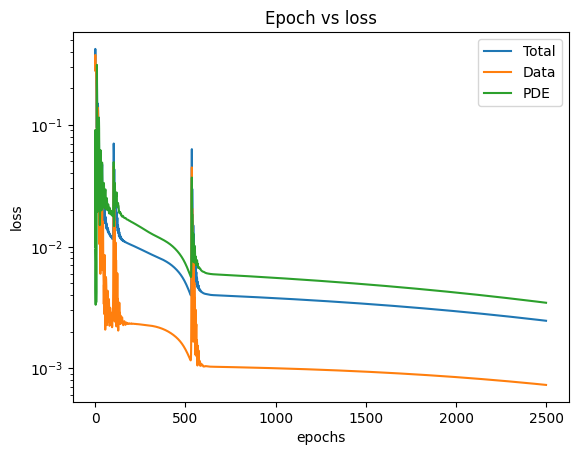

Train end


Test MSE Loss :  0.10829574803619044


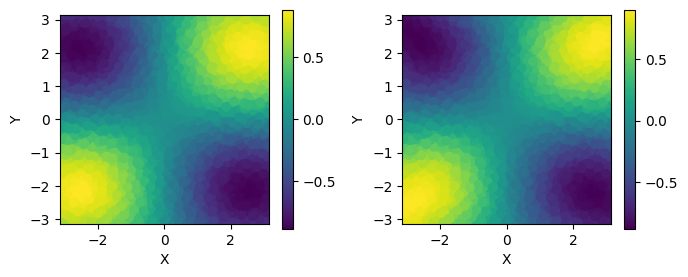

training with A:0.9926610113369381 B:1.0044676920990128 C:1.0638761184602317
Epoch 0/2500, Total Loss: 0.267078697681427, Data Loss: 0.2393426150083542, PDE Loss: 0.05547216534614563, LR: 0.02
Epoch 100/2500, Total Loss: 0.06662291288375854, Data Loss: 0.033082567155361176, PDE Loss: 0.06708068400621414, LR: 0.02
Epoch 200/2500, Total Loss: 0.012594012543559074, Data Loss: 0.006368930917233229, PDE Loss: 0.012450164183974266, LR: 0.006859999999999998
Epoch 300/2500, Total Loss: 0.004714322742074728, Data Loss: 0.001983215566724539, PDE Loss: 0.005462214350700378, LR: 0.004801999999999998
Epoch 400/2500, Total Loss: 0.0022362128365784883, Data Loss: 0.0009235096513293684, PDE Loss: 0.002625406254082918, LR: 0.004801999999999998
Epoch 500/2500, Total Loss: 0.0016677036182954907, Data Loss: 0.0006570381810888648, PDE Loss: 0.002021330874413252, LR: 0.0011529601999999994
Epoch 600/2500, Total Loss: 0.001432203920558095, Data Loss: 0.0005914912326261401, PDE Loss: 0.001681425259448588, LR: 

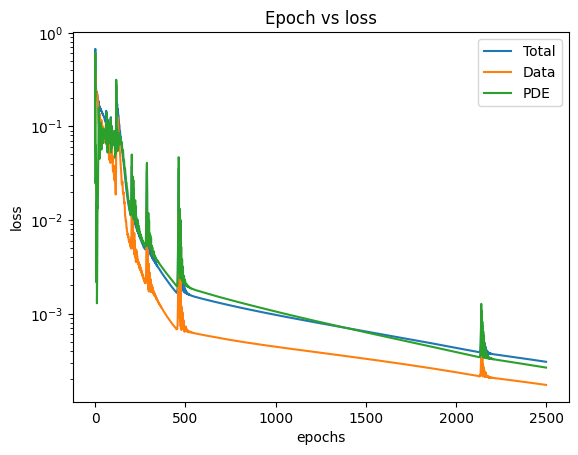

Train end


Test MSE Loss :  0.045815221709731735


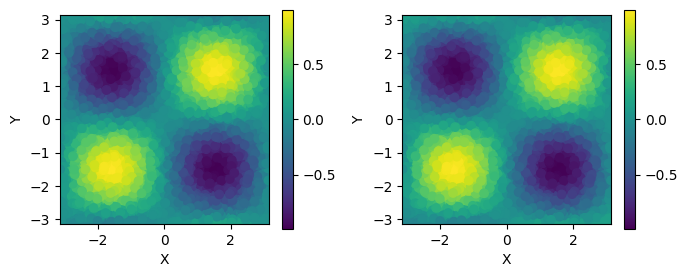

training with A:1.0600509553624107 B:1.80363778828612 C:0.8063141203855428
Epoch 0/2500, Total Loss: 0.4622713029384613, Data Loss: 0.37015652656555176, PDE Loss: 0.1842295527458191, LR: 0.02
Epoch 100/2500, Total Loss: 0.2871798276901245, Data Loss: 0.25960347056388855, PDE Loss: 0.05515274032950401, LR: 0.013999999999999999
Epoch 200/2500, Total Loss: 0.0888998806476593, Data Loss: 0.03930727019906044, PDE Loss: 0.09918522834777832, LR: 0.004801999999999998
Epoch 300/2500, Total Loss: 0.026443548500537872, Data Loss: 0.012150248512625694, PDE Loss: 0.028586601838469505, LR: 0.0033613999999999983
Epoch 400/2500, Total Loss: 0.015870455652475357, Data Loss: 0.008006901480257511, PDE Loss: 0.015727106481790543, LR: 0.002352979999999999
Epoch 500/2500, Total Loss: 0.01063272450119257, Data Loss: 0.0053907413966953754, PDE Loss: 0.010483966208994389, LR: 0.002352979999999999
Epoch 600/2500, Total Loss: 0.008556507527828217, Data Loss: 0.004293431062251329, PDE Loss: 0.008526152931153774, 

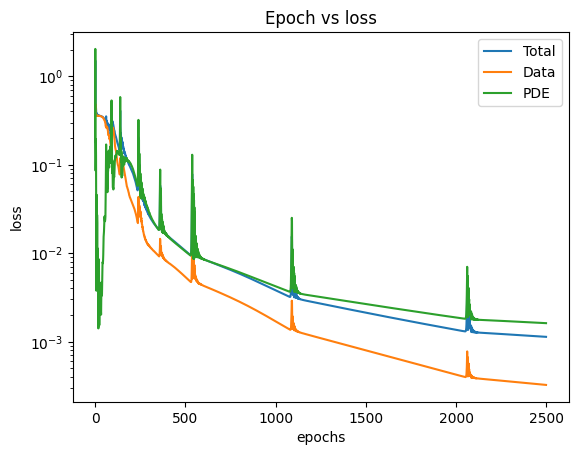

Train end


Test MSE Loss :  0.08634805783840116


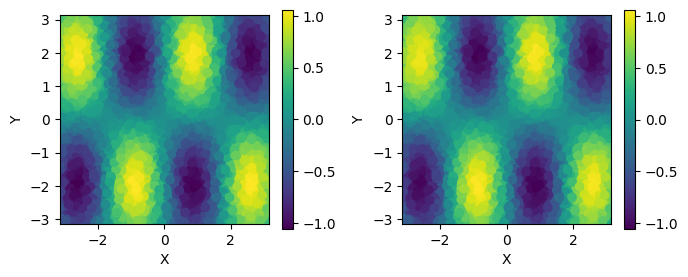

training with A:0.8056793994939285 B:1.667088624340879 C:0.6558453062090482
Epoch 0/2500, Total Loss: 0.28655850887298584, Data Loss: 0.22429955005645752, PDE Loss: 0.12451793998479843, LR: 0.02
Epoch 100/2500, Total Loss: 0.1782488375902176, Data Loss: 0.1438482403755188, PDE Loss: 0.06880119442939758, LR: 0.013999999999999999
Epoch 200/2500, Total Loss: 0.03460077941417694, Data Loss: 0.012939774431288242, PDE Loss: 0.04332200810313225, LR: 0.006859999999999998
Epoch 300/2500, Total Loss: 0.010276244953274727, Data Loss: 0.003510897746309638, PDE Loss: 0.01353069394826889, LR: 0.004801999999999998
Epoch 400/2500, Total Loss: 0.006308669224381447, Data Loss: 0.0023205408360809088, PDE Loss: 0.007976256310939789, LR: 0.002352979999999999
Epoch 500/2500, Total Loss: 0.004698914010077715, Data Loss: 0.0017969355685636401, PDE Loss: 0.005803956650197506, LR: 0.002352979999999999
Epoch 600/2500, Total Loss: 0.0034560777712613344, Data Loss: 0.0013129741419106722, PDE Loss: 0.00428620725870

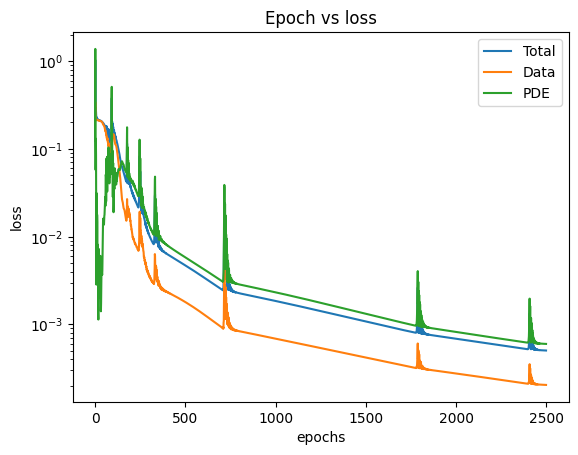

Train end


Test MSE Loss :  0.06559503762540933


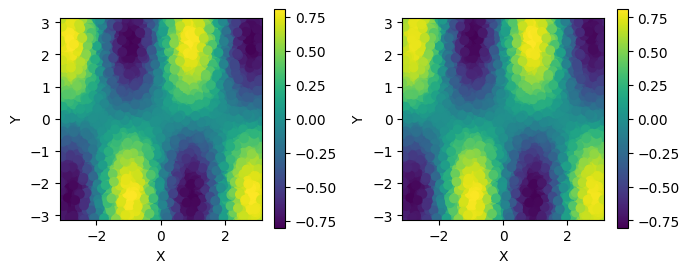

training with A:1.1142205550249682 B:1.551663418732249 C:1.8841221939248038
Epoch 0/2500, Total Loss: 0.5655731558799744, Data Loss: 0.3512600064277649, PDE Loss: 0.42862626910209656, LR: 0.02
Epoch 100/2500, Total Loss: 0.33230268955230713, Data Loss: 0.32961511611938477, PDE Loss: 0.005375157576054335, LR: 0.02
Epoch 200/2500, Total Loss: 0.3027362823486328, Data Loss: 0.2717151939868927, PDE Loss: 0.062042172998189926, LR: 0.009799999999999998
Epoch 300/2500, Total Loss: 0.24813880026340485, Data Loss: 0.2021503448486328, PDE Loss: 0.09197690337896347, LR: 0.004801999999999998
Epoch 400/2500, Total Loss: 0.2337023913860321, Data Loss: 0.1829456239938736, PDE Loss: 0.10151354968547821, LR: 0.0033613999999999983
Epoch 500/2500, Total Loss: 0.22547365725040436, Data Loss: 0.17795565724372864, PDE Loss: 0.09503600746393204, LR: 0.0016470859999999992
Epoch 600/2500, Total Loss: 0.21819989383220673, Data Loss: 0.16761039197444916, PDE Loss: 0.10117901116609573, LR: 0.0016470859999999992
E

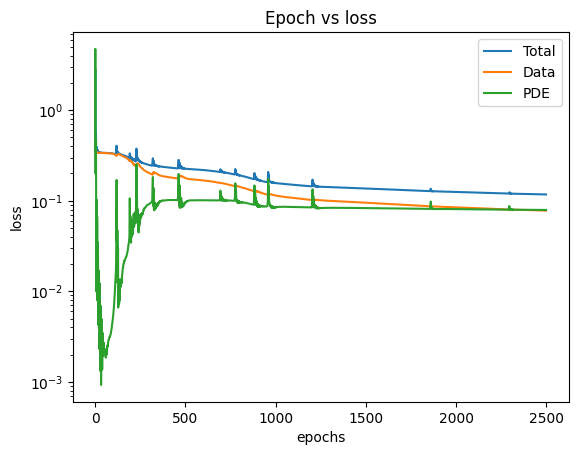

Train end


Test MSE Loss :  0.3925127998529911


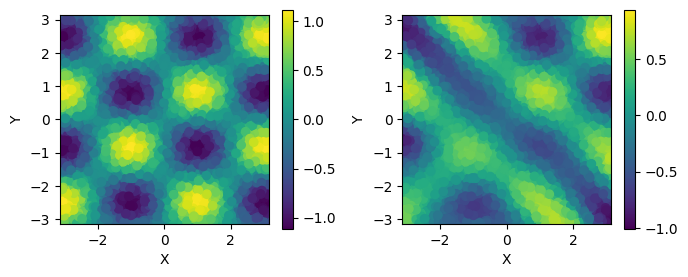

training with A:1.0113005341300303 B:1.1042978763708164 C:0.9825942665038673
Epoch 0/2500, Total Loss: 0.2770373225212097, Data Loss: 0.24816659092903137, PDE Loss: 0.0577414371073246, LR: 0.02
Epoch 100/2500, Total Loss: 0.07291902601718903, Data Loss: 0.038184985518455505, PDE Loss: 0.06946808099746704, LR: 0.013999999999999999
Epoch 200/2500, Total Loss: 0.012618537992238998, Data Loss: 0.005330677144229412, PDE Loss: 0.014575722627341747, LR: 0.0033613999999999983
Epoch 300/2500, Total Loss: 0.006035658530890942, Data Loss: 0.002578825457021594, PDE Loss: 0.006913665682077408, LR: 0.0033613999999999983
Epoch 400/2500, Total Loss: 0.004169145133346319, Data Loss: 0.0016531514702364802, PDE Loss: 0.005031987093389034, LR: 0.0033613999999999983
Epoch 500/2500, Total Loss: 0.002880849177017808, Data Loss: 0.0010288264602422714, PDE Loss: 0.003704045433551073, LR: 0.0033613999999999983
Epoch 600/2500, Total Loss: 0.002120131393894553, Data Loss: 0.0007266637403517962, PDE Loss: 0.002786

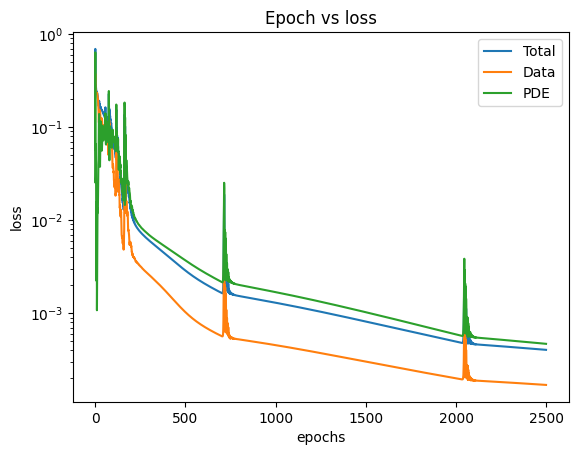

Train end


Test MSE Loss :  0.051190397343036334


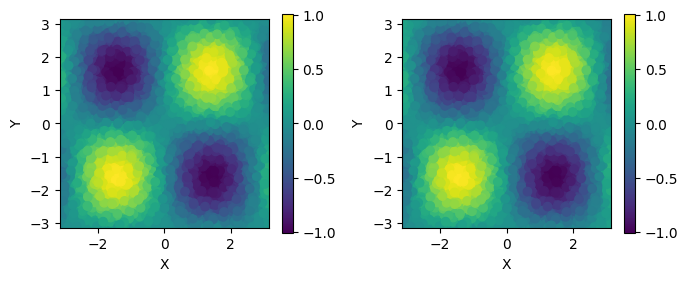

training with A:0.7807992483360096 B:1.2503325654877329 C:0.6434790402413546
Epoch 0/2500, Total Loss: 0.19369983673095703, Data Loss: 0.1700490117073059, PDE Loss: 0.04730165749788284, LR: 0.02
Epoch 100/2500, Total Loss: 0.03947165608406067, Data Loss: 0.017243923619389534, PDE Loss: 0.04445546865463257, LR: 0.02
Epoch 200/2500, Total Loss: 0.003969120793044567, Data Loss: 0.0009496133425273001, PDE Loss: 0.006039015017449856, LR: 0.006859999999999998
Epoch 300/2500, Total Loss: 0.0012231571599841118, Data Loss: 0.00011826836998807266, PDE Loss: 0.0022097774781286716, LR: 0.006859999999999998
Epoch 400/2500, Total Loss: 0.0009243901586160064, Data Loss: 8.780382631812245e-05, PDE Loss: 0.0016731726936995983, LR: 0.002352979999999999
Epoch 500/2500, Total Loss: 0.000742673350032419, Data Loss: 6.768569437554106e-05, PDE Loss: 0.0013499753549695015, LR: 0.002352979999999999
Epoch 600/2500, Total Loss: 0.0006119425524957478, Data Loss: 5.415049599832855e-05, PDE Loss: 0.0011155841639265

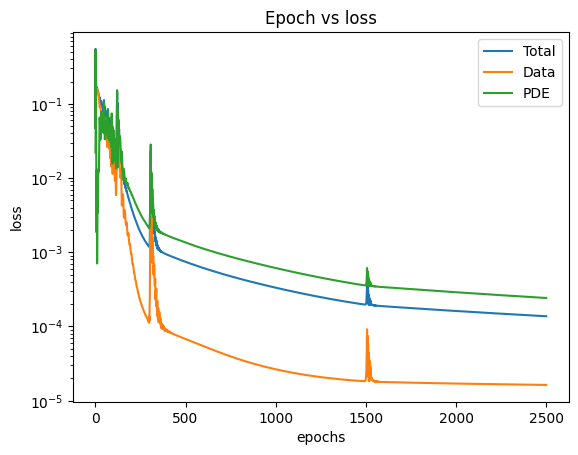

Train end


Test MSE Loss :  0.03049537971995053


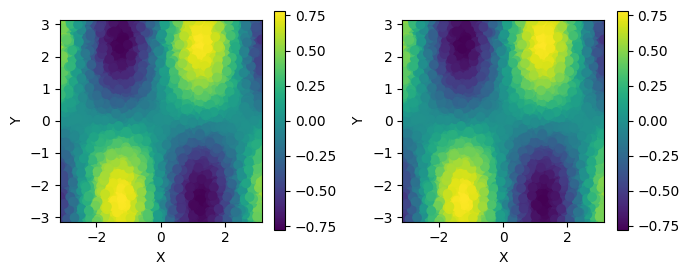

training with A:0.7170707652711635 B:1.2481880765132585 C:1.5748870026040955
Epoch 0/2500, Total Loss: 0.22725112736225128, Data Loss: 0.12871330976486206, PDE Loss: 0.19707563519477844, LR: 0.02
Epoch 100/2500, Total Loss: 0.1005549281835556, Data Loss: 0.0931222140789032, PDE Loss: 0.014865423552691936, LR: 0.013999999999999999
Epoch 200/2500, Total Loss: 0.07894173264503479, Data Loss: 0.05952318012714386, PDE Loss: 0.03883710876107216, LR: 0.002352979999999999
Epoch 300/2500, Total Loss: 0.06498634070158005, Data Loss: 0.04376759007573128, PDE Loss: 0.04243749752640724, LR: 0.002352979999999999
Epoch 400/2500, Total Loss: 0.051469773054122925, Data Loss: 0.031190453097224236, PDE Loss: 0.04055863618850708, LR: 0.0016470859999999992
Epoch 500/2500, Total Loss: 0.04817832633852959, Data Loss: 0.02555735595524311, PDE Loss: 0.04524194076657295, LR: 0.0016470859999999992
Epoch 600/2500, Total Loss: 0.040319349616765976, Data Loss: 0.021907765418291092, PDE Loss: 0.03682316839694977, LR

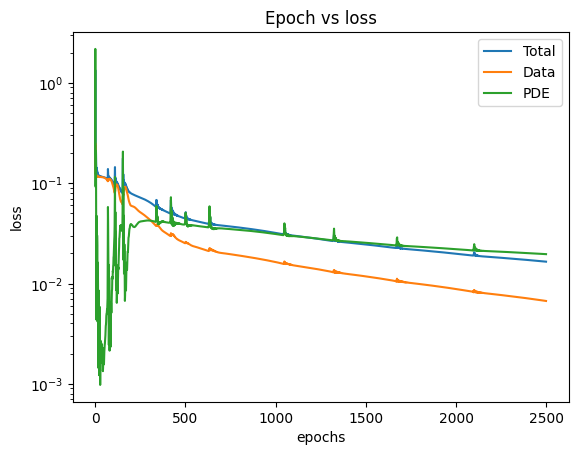

Train end


Test MSE Loss :  0.15347990766453573


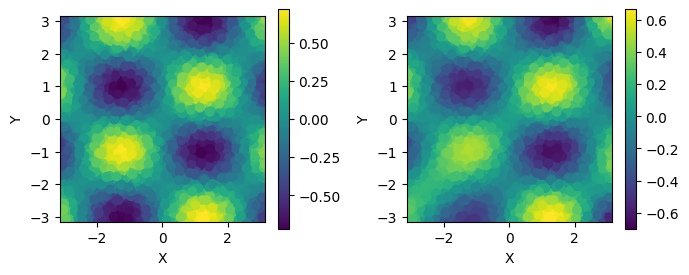

training with A:0.564789328106174 B:1.5367085495967512 C:1.9498958056687643
Epoch 0/2500, Total Loss: 0.3245795965194702, Data Loss: 0.09510394930839539, PDE Loss: 0.45895126461982727, LR: 0.02
Epoch 100/2500, Total Loss: 0.08354510366916656, Data Loss: 0.08312375843524933, PDE Loss: 0.0008426841231994331, LR: 0.02
Epoch 200/2500, Total Loss: 0.08336881548166275, Data Loss: 0.08317417651414871, PDE Loss: 0.000389278371585533, LR: 0.004801999999999998
Epoch 300/2500, Total Loss: 0.08251512795686722, Data Loss: 0.08217223733663559, PDE Loss: 0.0006857758271507919, LR: 0.00019377802081399983
Epoch 400/2500, Total Loss: 0.08247197419404984, Data Loss: 0.0821106880903244, PDE Loss: 0.0007225717417895794, LR: 7.819642097165965e-06
Epoch 500/2500, Total Loss: 0.08246999979019165, Data Loss: 0.08210784941911697, PDE Loss: 0.0007242950377985835, LR: 3.15550764069691e-07
Epoch 600/2500, Total Loss: 0.08246993273496628, Data Loss: 0.08210775256156921, PDE Loss: 0.0007243564468808472, LR: 2.598696

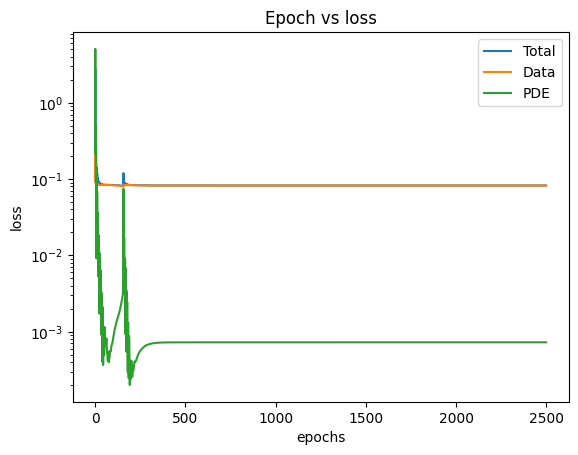

Train end


Test MSE Loss :  0.23726776243304643


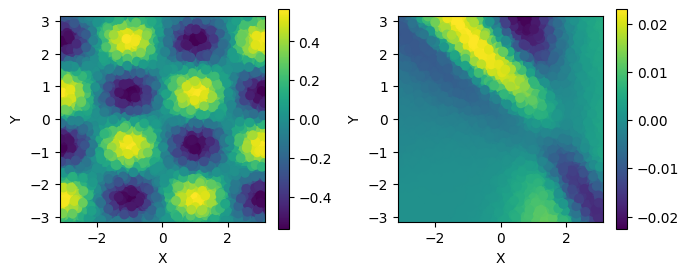

training with A:1.4414725726351811 B:0.9122516777264776 C:1.405664910808274
Epoch 0/2500, Total Loss: 0.5961524844169617, Data Loss: 0.5485032200813293, PDE Loss: 0.09529857337474823, LR: 0.02
Epoch 100/2500, Total Loss: 0.2933524250984192, Data Loss: 0.23123100399971008, PDE Loss: 0.12424281984567642, LR: 0.009799999999999998
Epoch 200/2500, Total Loss: 0.06823745369911194, Data Loss: 0.02358429878950119, PDE Loss: 0.0893063098192215, LR: 0.006859999999999998
Epoch 300/2500, Total Loss: 0.04542041942477226, Data Loss: 0.013947367668151855, PDE Loss: 0.06294610351324081, LR: 0.0033613999999999983
Epoch 400/2500, Total Loss: 0.028071992099285126, Data Loss: 0.007681288756430149, PDE Loss: 0.0407814085483551, LR: 0.0033613999999999983
Epoch 500/2500, Total Loss: 0.02149210311472416, Data Loss: 0.0058215404860675335, PDE Loss: 0.03134112432599068, LR: 0.0011529601999999994
Epoch 600/2500, Total Loss: 0.018083499744534492, Data Loss: 0.004655466880649328, PDE Loss: 0.026856066659092903, LR

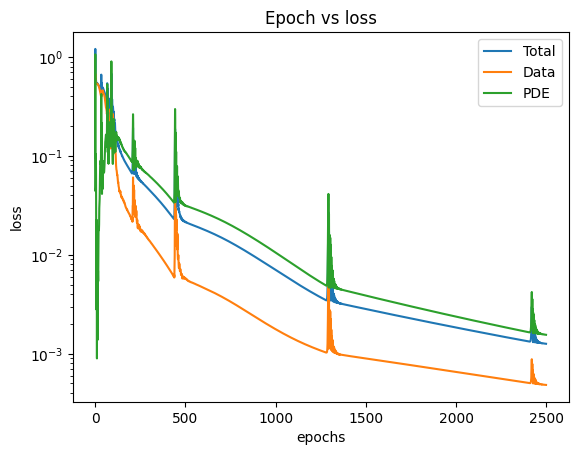

Train end


Test MSE Loss :  0.09476320027520022


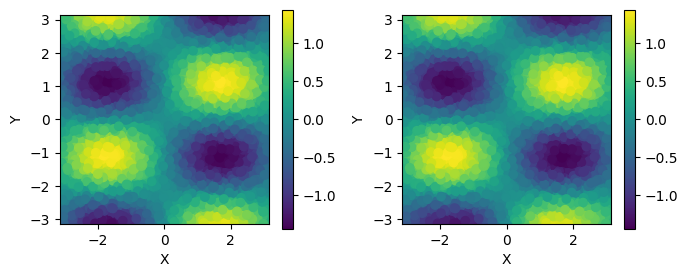

training with A:0.6964663563181073 B:0.8714126073073516 C:0.8858933764210435
Epoch 0/2500, Total Loss: 0.1819555163383484, Data Loss: 0.16752596199512482, PDE Loss: 0.028859112411737442, LR: 0.02
Epoch 100/2500, Total Loss: 0.037597157061100006, Data Loss: 0.027299880981445312, PDE Loss: 0.02059454843401909, LR: 0.02
Epoch 200/2500, Total Loss: 0.0018630367703735828, Data Loss: 0.0004082167870365083, PDE Loss: 0.002909640083089471, LR: 0.006859999999999998
Epoch 300/2500, Total Loss: 0.0005744679947383702, Data Loss: 0.0001239138509845361, PDE Loss: 0.0009011083166114986, LR: 0.006859999999999998
Epoch 400/2500, Total Loss: 0.0002971701032947749, Data Loss: 6.449551437981427e-05, PDE Loss: 0.00046534917782992125, LR: 0.006859999999999998
Epoch 500/2500, Total Loss: 0.00018455064855515957, Data Loss: 3.875221955240704e-05, PDE Loss: 0.00029159686528146267, LR: 0.006859999999999998
Epoch 600/2500, Total Loss: 0.0001290440559387207, Data Loss: 2.5485049263807014e-05, PDE Loss: 0.000207118

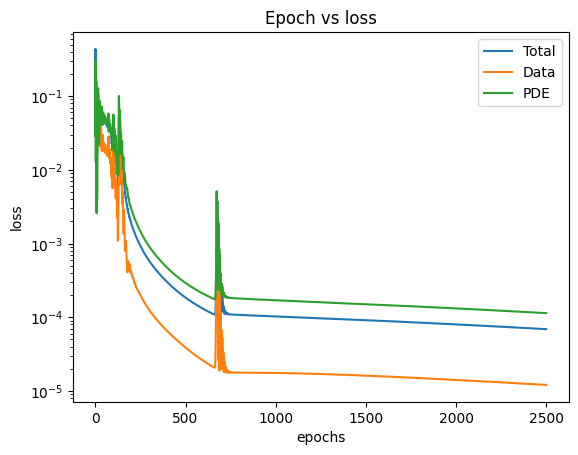

Train end


Test MSE Loss :  0.029162558269623638


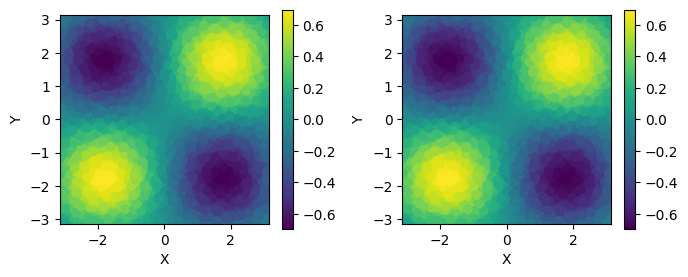

training with A:0.5286829503741566 B:1.9697624738125876 C:1.8280660150877082
Epoch 0/2500, Total Loss: 0.4034864008426666, Data Loss: 0.08846915513277054, PDE Loss: 0.6300345063209534, LR: 0.02
Epoch 100/2500, Total Loss: 0.07520261406898499, Data Loss: 0.07497727125883102, PDE Loss: 0.00045067930477671325, LR: 0.02
Epoch 200/2500, Total Loss: 0.07455773651599884, Data Loss: 0.07396607846021652, PDE Loss: 0.0011833127355203032, LR: 0.02
Epoch 300/2500, Total Loss: 0.0755344033241272, Data Loss: 0.07551884651184082, PDE Loss: 3.111760088359006e-05, LR: 0.002352979999999999
Epoch 400/2500, Total Loss: 0.07552055269479752, Data Loss: 0.07550019770860672, PDE Loss: 4.0706032450543717e-05, LR: 9.49512301988599e-05
Epoch 500/2500, Total Loss: 0.07552006840705872, Data Loss: 0.07549958676099777, PDE Loss: 4.096888369531371e-05, LR: 3.831624627611323e-06
Epoch 600/2500, Total Loss: 0.07552004605531693, Data Loss: 0.07549955695867538, PDE Loss: 4.097956116311252e-05, LR: 1.5461987439414858e-07


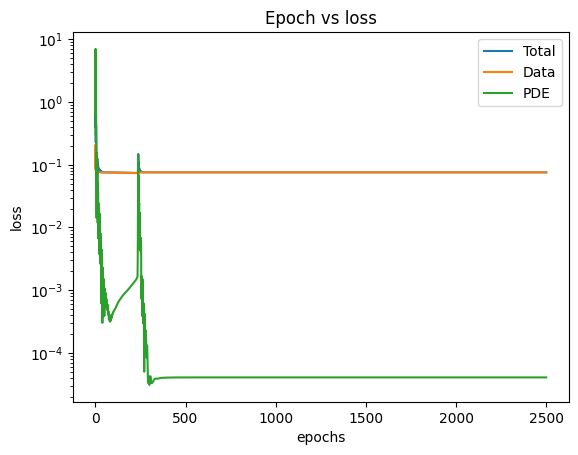

Train end


Test MSE Loss :  0.22853369225865452


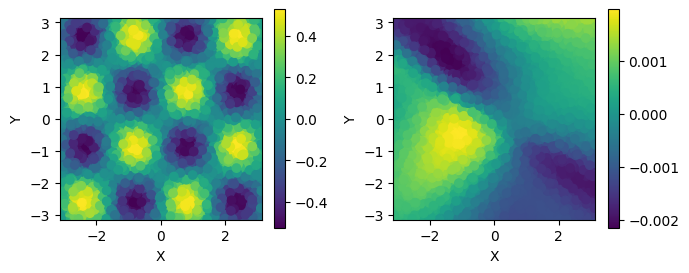

training with A:1.1550933504346717 B:1.3479038854802354 C:1.2269056767996454
Epoch 0/2500, Total Loss: 0.34246957302093506, Data Loss: 0.2757377326488495, PDE Loss: 0.13346365094184875, LR: 0.02
Epoch 100/2500, Total Loss: 0.22381837666034698, Data Loss: 0.20375004410743713, PDE Loss: 0.040136657655239105, LR: 0.009799999999999998
Epoch 200/2500, Total Loss: 0.1267584264278412, Data Loss: 0.0761592909693718, PDE Loss: 0.10119825601577759, LR: 0.009799999999999998
Epoch 300/2500, Total Loss: 0.06706312298774719, Data Loss: 0.03349335119128227, PDE Loss: 0.06713955104351044, LR: 0.004801999999999998
Epoch 400/2500, Total Loss: 0.0455174520611763, Data Loss: 0.01961078867316246, PDE Loss: 0.05181332305073738, LR: 0.002352979999999999
Epoch 500/2500, Total Loss: 0.05456540733575821, Data Loss: 0.021998321637511253, PDE Loss: 0.06513417512178421, LR: 0.0016470859999999992
Epoch 600/2500, Total Loss: 0.027018269523978233, Data Loss: 0.010110611096024513, PDE Loss: 0.03381531685590744, LR: 0.

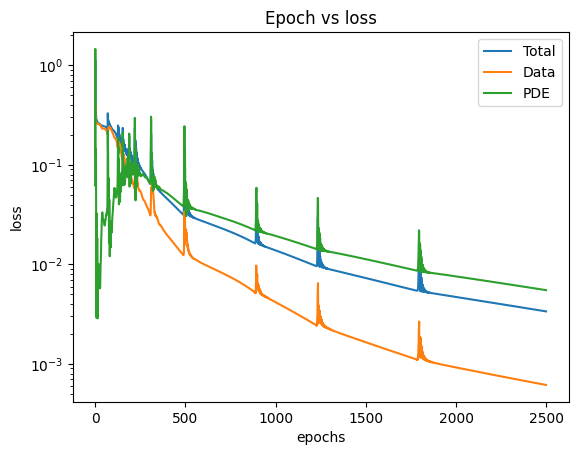

Train end


Test MSE Loss :  0.09262632515138462


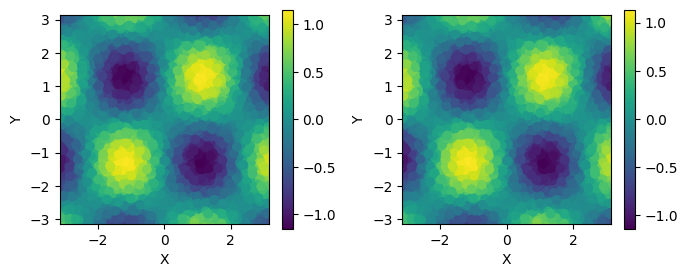

training with A:1.215064271879887 B:1.033489549337249 C:1.319033954472093
Epoch 0/2500, Total Loss: 0.37595900893211365, Data Loss: 0.3282758593559265, PDE Loss: 0.09536632150411606, LR: 0.02
Epoch 100/2500, Total Loss: 0.09604768455028534, Data Loss: 0.05628003925085068, PDE Loss: 0.07953528314828873, LR: 0.013999999999999999
Epoch 200/2500, Total Loss: 0.031155452132225037, Data Loss: 0.01598920300602913, PDE Loss: 0.030332498252391815, LR: 0.009799999999999998
Epoch 300/2500, Total Loss: 0.019172372296452522, Data Loss: 0.010328183881938457, PDE Loss: 0.01768837682902813, LR: 0.004801999999999998
Epoch 400/2500, Total Loss: 0.010040047578513622, Data Loss: 0.0051976353861391544, PDE Loss: 0.009684824384748936, LR: 0.004801999999999998
Epoch 500/2500, Total Loss: 0.0077259596437215805, Data Loss: 0.004074564203619957, PDE Loss: 0.007302791345864534, LR: 0.0016470859999999992
Epoch 600/2500, Total Loss: 0.005948648788034916, Data Loss: 0.002980603603646159, PDE Loss: 0.005936089903116

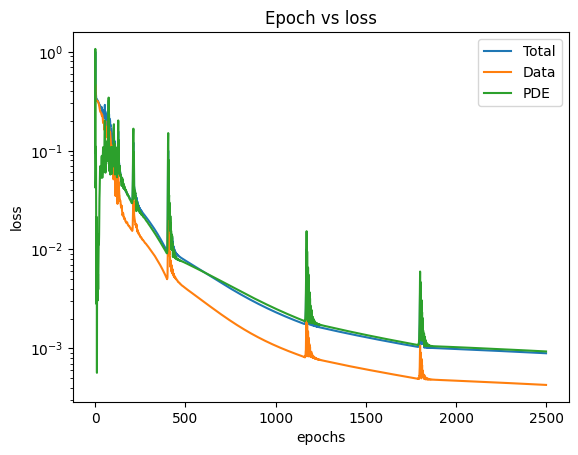

Train end


Test MSE Loss :  0.07172286648950582


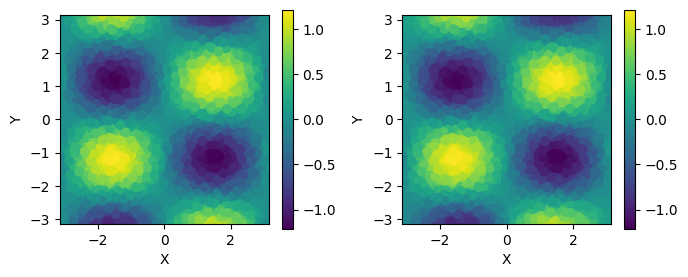

training with A:1.465259158983664 B:1.8509863151745332 C:1.7394468677552821
Epoch 0/2500, Total Loss: 0.8865383863449097, Data Loss: 0.6349761486053467, PDE Loss: 0.5031244158744812, LR: 0.02
Epoch 100/2500, Total Loss: 0.603804886341095, Data Loss: 0.5895147919654846, PDE Loss: 0.02858022414147854, LR: 0.02
Epoch 200/2500, Total Loss: 0.5223578810691833, Data Loss: 0.4703318178653717, PDE Loss: 0.10405214875936508, LR: 0.009799999999999998
Epoch 300/2500, Total Loss: 0.47837433218955994, Data Loss: 0.4054095447063446, PDE Loss: 0.14592956006526947, LR: 0.006859999999999998
Epoch 400/2500, Total Loss: 0.43684253096580505, Data Loss: 0.36767539381980896, PDE Loss: 0.13833428919315338, LR: 0.0033613999999999983
Epoch 500/2500, Total Loss: 0.3775361478328705, Data Loss: 0.28515636920928955, PDE Loss: 0.18475955724716187, LR: 0.002352979999999999
Epoch 600/2500, Total Loss: 0.35022756457328796, Data Loss: 0.2572561204433441, PDE Loss: 0.1859428733587265, LR: 0.0016470859999999992
Epoch 700

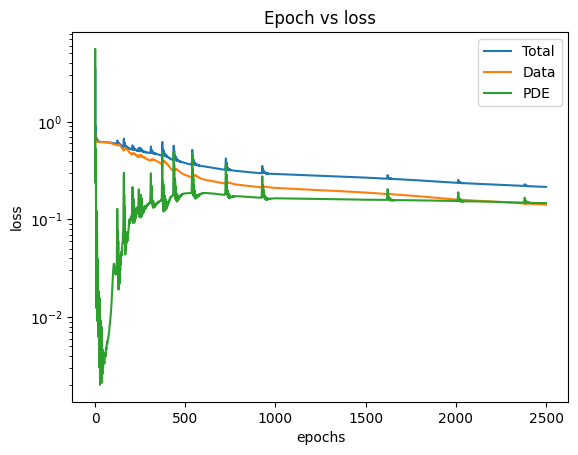

Train end


Test MSE Loss :  0.5369284797365018


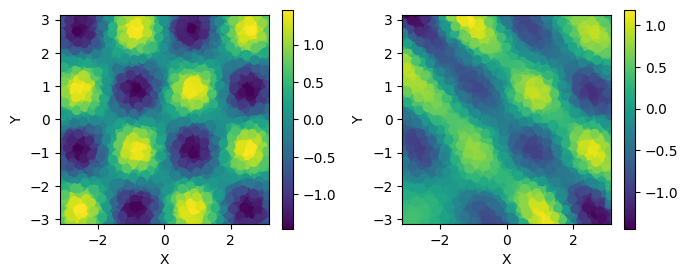

training with A:1.2516291665726755 B:0.6855972644708601 C:1.1553484825375557
Epoch 0/2500, Total Loss: 0.45224636793136597, Data Loss: 0.4325372874736786, PDE Loss: 0.039418138563632965, LR: 0.02
Epoch 100/2500, Total Loss: 0.08410879969596863, Data Loss: 0.048788223415613174, PDE Loss: 0.0706411600112915, LR: 0.013999999999999999
Epoch 200/2500, Total Loss: 0.0362478643655777, Data Loss: 0.012692034244537354, PDE Loss: 0.04711165651679039, LR: 0.002352979999999999
Epoch 300/2500, Total Loss: 0.007066564634442329, Data Loss: 0.0021782005205750465, PDE Loss: 0.009776728227734566, LR: 0.002352979999999999
Epoch 400/2500, Total Loss: 0.0027482304722070694, Data Loss: 0.0008068068418651819, PDE Loss: 0.0038828470278531313, LR: 0.002352979999999999
Epoch 500/2500, Total Loss: 0.0014768363907933235, Data Loss: 0.0003953718696720898, PDE Loss: 0.0021629289258271456, LR: 0.002352979999999999
Epoch 600/2500, Total Loss: 0.0010450606932863593, Data Loss: 0.0002666758082341403, PDE Loss: 0.001556

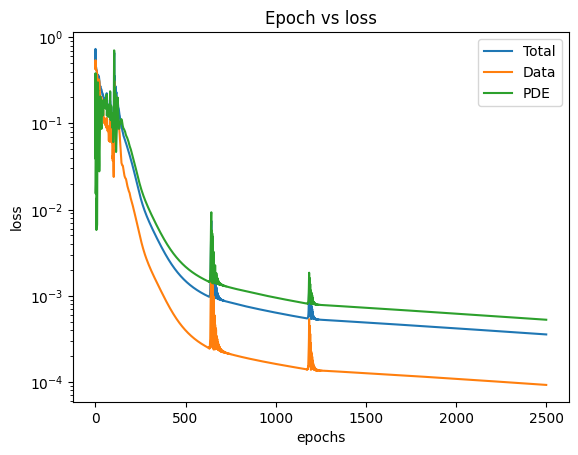

Train end


Test MSE Loss :  0.05462829772478633


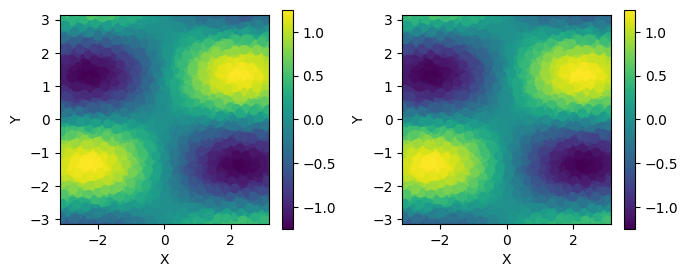

training with A:1.3793156162463651 B:1.4235602716612665 C:0.5256465964473
Epoch 0/2500, Total Loss: 0.5126099586486816, Data Loss: 0.4805366098880768, PDE Loss: 0.06414663791656494, LR: 0.02
Epoch 100/2500, Total Loss: 0.16077256202697754, Data Loss: 0.10006750375032425, PDE Loss: 0.12141013145446777, LR: 0.009799999999999998
Epoch 200/2500, Total Loss: 0.02650192566215992, Data Loss: 0.006563233677297831, PDE Loss: 0.03987738490104675, LR: 0.006859999999999998
Epoch 300/2500, Total Loss: 0.016171641647815704, Data Loss: 0.003543296828866005, PDE Loss: 0.0252566896378994, LR: 0.004801999999999998
Epoch 400/2500, Total Loss: 0.01094804797321558, Data Loss: 0.0024827702436596155, PDE Loss: 0.016930555924773216, LR: 0.004801999999999998
Epoch 500/2500, Total Loss: 0.00907936505973339, Data Loss: 0.0020598205737769604, PDE Loss: 0.014039088040590286, LR: 0.002352979999999999
Epoch 600/2500, Total Loss: 0.007772538810968399, Data Loss: 0.0016750342911109328, PDE Loss: 0.012195008806884289, 

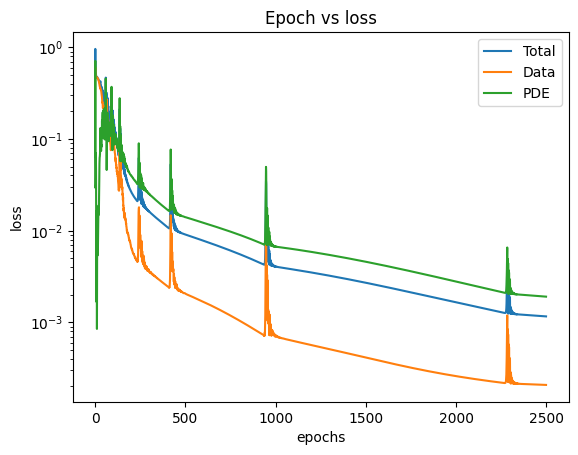

Train end


Test MSE Loss :  0.07946930417885344


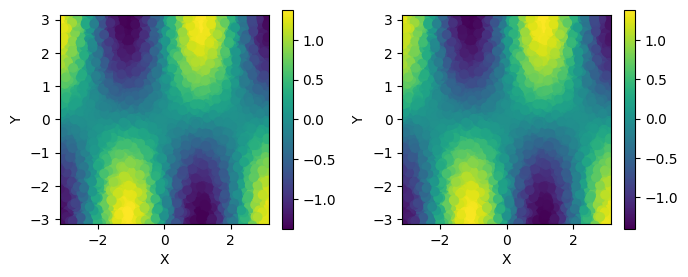

training with A:0.6461435586370163 B:0.7519880200471808 C:1.3459413475493847
Epoch 0/2500, Total Loss: 0.15911871194839478, Data Loss: 0.12495839595794678, PDE Loss: 0.0683206245303154, LR: 0.02
Epoch 100/2500, Total Loss: 0.04620586708188057, Data Loss: 0.0336461216211319, PDE Loss: 0.025119490921497345, LR: 0.009799999999999998
Epoch 200/2500, Total Loss: 0.005920726805925369, Data Loss: 0.001192896394059062, PDE Loss: 0.009455661289393902, LR: 0.006859999999999998
Epoch 300/2500, Total Loss: 0.0035394851583987474, Data Loss: 0.0007235687808133662, PDE Loss: 0.005631832871586084, LR: 0.0033613999999999983
Epoch 400/2500, Total Loss: 0.002733825473114848, Data Loss: 0.0005556364194490016, PDE Loss: 0.004356378223747015, LR: 0.0033613999999999983
Epoch 500/2500, Total Loss: 0.0022745158057659864, Data Loss: 0.000468539452413097, PDE Loss: 0.0036119527649134398, LR: 0.0033613999999999983
Epoch 600/2500, Total Loss: 0.001901946496218443, Data Loss: 0.00039875705260783434, PDE Loss: 0.003

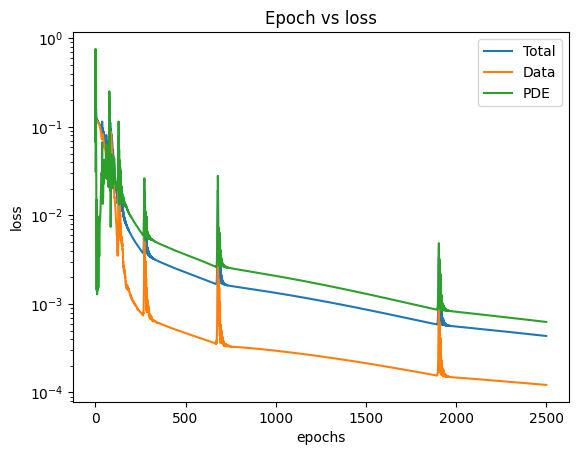

Train end


Test MSE Loss :  0.05192189551786296


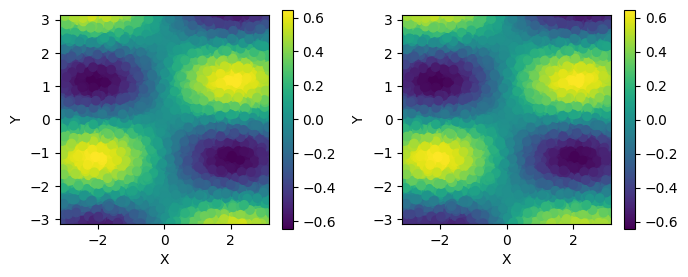

training with A:0.9481901383571353 B:1.736580824767281 C:1.633252245395024
Epoch 0/2500, Total Loss: 0.4743739068508148, Data Loss: 0.27911999821662903, PDE Loss: 0.3905078172683716, LR: 0.02
Epoch 100/2500, Total Loss: 0.26164036989212036, Data Loss: 0.2596346437931061, PDE Loss: 0.0040114750154316425, LR: 0.013999999999999999
Epoch 200/2500, Total Loss: 0.22491583228111267, Data Loss: 0.21068039536476135, PDE Loss: 0.028470879420638084, LR: 0.009799999999999998
Epoch 300/2500, Total Loss: 0.2060748189687729, Data Loss: 0.1824059784412384, PDE Loss: 0.04733768105506897, LR: 0.002352979999999999
Epoch 400/2500, Total Loss: 0.1922960877418518, Data Loss: 0.16078776121139526, PDE Loss: 0.06301666051149368, LR: 0.002352979999999999
Epoch 500/2500, Total Loss: 0.17591026425361633, Data Loss: 0.1415986567735672, PDE Loss: 0.06862320750951767, LR: 0.0011529601999999994
Epoch 600/2500, Total Loss: 0.16671374440193176, Data Loss: 0.12608271837234497, PDE Loss: 0.08126203715801239, LR: 0.001152

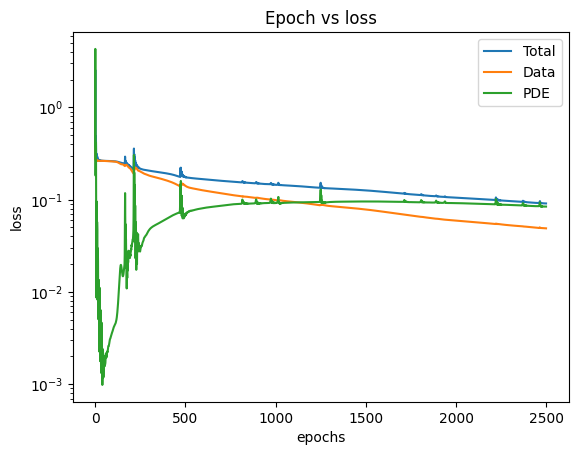

Train end


Test MSE Loss :  0.33297843479190814


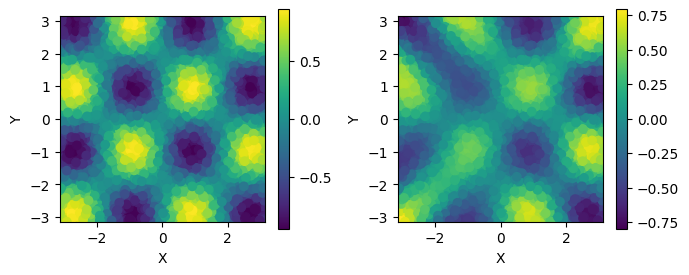

training with A:1.3027367182262846 B:0.5521091050706922 C:1.4942715403090903
Epoch 0/2500, Total Loss: 0.5162885785102844, Data Loss: 0.4773293435573578, PDE Loss: 0.07791851460933685, LR: 0.02
Epoch 100/2500, Total Loss: 0.17392848432064056, Data Loss: 0.10109531879425049, PDE Loss: 0.14566633105278015, LR: 0.006859999999999998
Epoch 200/2500, Total Loss: 0.034210268408060074, Data Loss: 0.010093946941196918, PDE Loss: 0.04823264479637146, LR: 0.006859999999999998
Epoch 300/2500, Total Loss: 0.013287227600812912, Data Loss: 0.0036468221805989742, PDE Loss: 0.01928081177175045, LR: 0.0033613999999999983
Epoch 400/2500, Total Loss: 0.00791312288492918, Data Loss: 0.0019912507850676775, PDE Loss: 0.011843744665384293, LR: 0.0033613999999999983
Epoch 500/2500, Total Loss: 0.004532018210738897, Data Loss: 0.0009896104456856847, PDE Loss: 0.007084815762937069, LR: 0.0033613999999999983
Epoch 600/2500, Total Loss: 0.013151708990335464, Data Loss: 0.0037772166542708874, PDE Loss: 0.0187489856

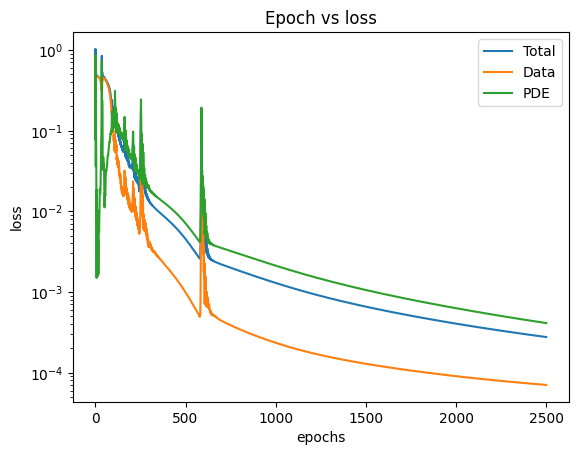

Train end


Test MSE Loss :  0.06235784307940373


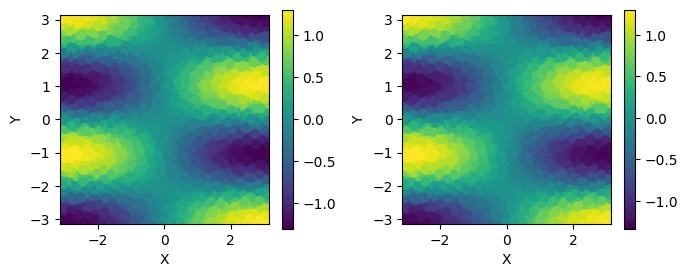

In [15]:
for task in tasks:
    ABC = task.split("_")[1:4]
    print(f"training with A:{ABC[0]} B:{ABC[1]} C:{ABC[2]}")
    A = torch.tensor(float(ABC[0]), dtype=torch.float)
    B = torch.tensor(float(ABC[1]), dtype=torch.float)
    C = torch.tensor(float(ABC[2]), dtype=torch.float)
    
    # 데이터를 준비합니다.
    with open(task, 'rb') as f:
        data = np.load(f,allow_pickle=True)
    x_data = data.T[0]
    y_data = data.T[1]
    f_data = A*np.sin(B*x_data) * np.sin(C*y_data)
    xy_data = np.stack([x_data.ravel(), y_data.ravel()], axis=-1)
    xy_data = torch.tensor(xy_data, dtype=torch.float)
    f_data = torch.tensor(f_data.ravel(), dtype=torch.float).view(-1, 1)

    A = A.to(device)
    B = B.to(device)
    C = C.to(device)
    # 데이터 로더를 생성합니다.
    loader = create_dataloader(xy_data, f_data, batch_size, shuffle)

    # 모델을 GPU로 이동합니다(만약 사용 가능하다면).
    model = NN(mask=True)
    model.load_state_dict(torch.load("./data/model.pt"))
    model = model.to(device)
    # loss
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=10, verbose=False)

    # init
    loss_history = []
    data_loss_history = []
    pde_loss_history = []
    best_loss = float('inf')
    
    #### 훈련 시작 ####
    
    model = train_model(model, epochs, A=A, B=B, C=C)
    print("Train end\n\n")
    loss = test_inference(model, task)
    if loss <= 0.2:
        torch.save(model.state_dict(), f"./data/model_{ABC[0]}_{ABC[1]}_{ABC[2]}_.pt")